# MMT Class Assignment
## Topic - Genre Classification
> Samyak Jain (20161083),
> Yudhik Agrawal (20161093)

### Overview
For the given task of unsupervised genre classification, we used two different approaches: Agglomerative Algorithm (Dendogram) and KMeans Clustering. We manually identified the clusters as Energetic, Classical, Devotional, Soulful & Sad and the distribution was 212, 67, 182 and 166

In [1]:
import warnings
warnings.filterwarnings('ignore')
import librosa
import sklearn
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
import os
from six.moves import cPickle as pickle
from sklearn.preprocessing import StandardScaler
from IPython.display import display,Audio,HTML

### Zero Crossing Rate

In [2]:
def zero_crossing(x, sr):
    zero_crossings = librosa.zero_crossings(x, pad=False)
    return zero_crossings

### Spectral Centroid

In [3]:
def spectral_centroid(x, sr):
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    return spectral_centroids;


### Spectral Rolloff

In [4]:
def spectral_rolloff(x, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
    return spectral_rolloff

### MFCC

In [5]:
def mfcc(x, sr, num):
    mfccs = librosa.feature.mfcc(x, n_mfcc=num, sr=sr)
    return mfccs.flatten()

### Getting the Features
* We calculated different features for each song like MFCC, Spectral Rolloff, Spectral Centroid and Zero Crossing
* We normalized every feature in its domain for giving equal contribution to each feature.
* We combined them and have a single clustering.

In [9]:
def feature_extractor(audio_path, mf = False, sc = False, zc = False, sroll = False):
    x , sr = librosa.load(audio_path, sr=44100)
    return (np.sum(zero_crossing(x, sr)), spectral_centroid(x, sr), mfcc(x, sr, 5), spectral_rolloff(x, sr))

def get_features(data_path="IndianSongsDataset/data"):
    cnt=0
    paths = list()
    for language in sorted(os.listdir(data_path)):
        curr_path = os.path.join(data_path, language)
        for _dir in sorted(os.listdir(curr_path)):
            if(_dir == 'normal'): continue
            new_path = os.path.join(curr_path, _dir)
            for song in sorted(os.listdir(new_path)):
                newer_path = os.path.join(new_path, song)
                paths.append(newer_path)
    print(len(paths))
    features = {'mfcc':[],'sc':[],'sroll':[],'zc':[]}
    for i, path in enumerate(paths):
        print(i,end='\r')
        f1, f2, f3, f4 = feature_extractor(path, mf = True, sc = False, zc = False, sroll = False)
        features['zc'].append(f1)
        features['sc'].append(f2)
        features['mfcc'].append(f3)
        features['sroll'].append(f4)
    for i in range(len(features['zc'])):
        features['zc'] = np.array(features['zc'])
        features['zc'] = np.reshape(features['zc'], (-1, 1))
    
    
    features['paths'] = paths
    features['sc'] = np.array(features['sc'])
    features['zc'] = np.array(features['zc'])
    features['mfcc'] = np.array(features['mfcc'])
    features['sroll'] = np.array(features['sroll'])
    
    return features

# features = get_features()

627


In [10]:
# def save_dict(di_, filename_):
#     with open(filename_, 'wb') as f:
#         pickle.dump(di_, f)
# def load_dict(filename_):
#     with open(filename_, 'rb') as f:
#         ret_di = pickle.load(f)
#     return ret_di

# save_dict(features, 'features.pkl')

# Combined Features

In [11]:
features = load_dict('./features.pkl')
# print(features['sc'].shape)

(627, 2590)


In [12]:
def normalize(x):
    scaler = StandardScaler()
    scaler.fit(x)
    return scaler.transform(x)

features['sc_n'] = normalize(features['sc'])
features['zc_n'] = normalize(features['zc'])
features['mfcc_n'] = normalize(features['mfcc'])
features['sroll_n'] = normalize(features['sroll'])
features['combined_features'] = np.concatenate((features['sc_n'], features['mfcc_n'], \
                                                features['sroll_n'], features['zc_n']), 1)

In [13]:
features['combined_features'].shape

(627, 18131)

### Testing

In [14]:
import random
from scipy.spatial import distance
x = random.randint(0,627)
y = random.randint(0,627)
print(distance.euclidean(features['combined_features'][x][:2590], features['combined_features'][y][:2590])/2590**0.5)
print(distance.euclidean(features['combined_features'][x][2590:2590+12950], features['combined_features'][y][2590:2590+12950])/12950**0.5)
print(distance.euclidean(features['combined_features'][x][2590+12950:2590+12950+2590] , features['combined_features'][y][2590+12950:2590+12950+2590])/2590**0.5)
print(distance.euclidean(features['combined_features'][x][-1] , features['combined_features'][y][-1]))
print(features['combined_features'][x][-1] , features['combined_features'][y][-1])

2.2100837216705504
1.595062154994962
2.146551995645137
1.0974673463853426
-1.0677824579964523 0.029684888388890284


## KMeans Clustering

In [15]:
num_clusters = 4
clf = sklearn.cluster.KMeans(n_clusters=num_clusters)
kmeans = clf.fit(features['combined_features'])
labels = kmeans.labels_

In [16]:
paths = features['paths']

In [17]:
def show_cluster(labels, num_clusters = 4, curr_cluster_num = 2):
    playlist_html=""
    audio_html=""
    music_dir = u'Music'
    count=0
    
    def play_audio(audio_path):
        ipd.Audio(audio_path)

    def get_audio_cluster(labels, num_clust = num_clusters, curr_cluster_num = curr_cluster_num):
        cl_paths = list()
        curr_labels = labels
        for i in range(len(curr_labels)):
            if(curr_labels[i] == curr_cluster_num):
                cl_paths.append(paths[i])
        return cl_paths
    
    cl_paths = get_audio_cluster(labels, num_clust = num_clusters)

    for file in cl_paths:
        if count==0:
            playlist_html = u'''<li class="active"><a href="{0}">{1}</a>
                </li>\n'''.format(file, file.split('/')[-1])
            audio_html = u'''<audio id="audio" preload="auto" tabindex="0" controls="" type="audio/mpeg">
                <source type="audio/mp3" src="{}">Sorry, your browser does not support HTML5 audio.
                </audio>'''.format(file)
        else:
            playlist_html +=u'''<li><a href="{0}">{1}</a></li>\n'''.format(file, file)
        count += 1

    playlist_html = audio_html + u'''\n<ol id="playlist">\n{}</ol>'''.format(playlist_html)
    #print playlist_html


    playlist_css = """
    <style>
    #playlist .active a{color:#CC0000;text-decoration:none;}
    #playlist li a:hover{text-decoration:none;}
    </style>
    """

    playlist_js = """
    <script>
    var audio;
    var playlist;
    var tracks;
    var current;

    init();
    function init(){
        current = 0;
        audio = $('audio');
        playlist = $('#playlist');
        tracks = playlist.find('li a');
        len = tracks.length - 1;
        audio[0].volume = .10;
        playlist.find('a').click(function(e){
            e.preventDefault();
            link = $(this);
            current = link.parent().index();
            run(link, audio[0]);
        });
        audio[0].addEventListener('ended',function(e){
            current++;
            if(current == len){
                current = 0;
                link = playlist.find('a')[0];
            }else{
                link = playlist.find('a')[current];    
            }
            run($(link),audio[0]);
        });
    }
    function run(link, player){
            player.src = link.attr('href');
            par = link.parent();
            par.addClass('active').siblings().removeClass('active');
            audio[0].load();
            audio[0].play();
    }
    </script>
    """
    display(HTML(playlist_html))
    display(HTML(playlist_css))
    display(HTML(playlist_js))

## Energetic

In [18]:
show_cluster(labels, num_clusters=num_clusters, curr_cluster_num=0)

## Classical

In [19]:
show_cluster(labels, num_clusters=num_clusters, curr_cluster_num=1)

## Devotional

In [20]:
show_cluster(labels, num_clusters=num_clusters, curr_cluster_num=2)

## Soulful and Sad

In [21]:
show_cluster(labels, num_clusters=num_clusters, curr_cluster_num=3)

## Dendogram

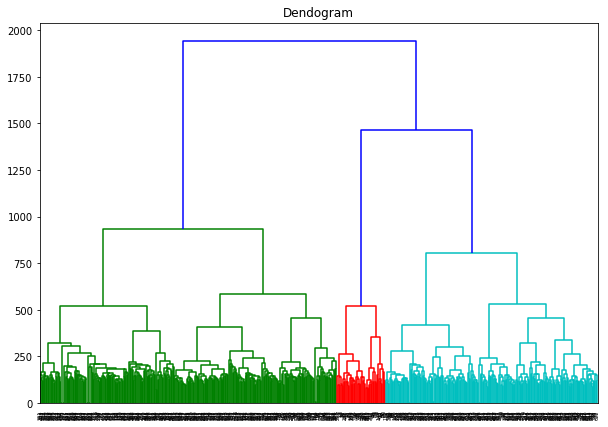

In [36]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendogram")
link = shc.linkage(features['combined_features'], method='ward')
dend = shc.dendrogram(link)

## We analyzed that KMeans Cluster were more diverse than the Dendograms